In [97]:
from keras.models import load_model
import joblib
import numpy as np
import pandas as pd
import glob
import seaborn as sb
import matplotlib.pyplot as plt

In [80]:
TRAIN_PATH = '../data/final_model/train/train_data.joblib'
TEST_PATH = '../data/final_model/test/test_data.joblib'
UNCERTAID_PATH = '../data/final_model/uncerated/uncerated.joblib'

FOLDER_MODEL = '../model/FINAL_MODEL/03-06-2024_11-51/'

In [92]:
def load_data(path_data: str, types = None) -> tuple:
    X = None
    y = None
    data_loaded = joblib.load(path_data)
    
    if types == 'Uncerated':
        return data_loaded
        
        
    X = data_loaded['X']
    y = data_loaded['y']
    
    all_stars = np.array([s.split('_')[1] for s in data_loaded['sample_names']]) # lấy ra star alen: 10, 1, 2, ...
    stars, idx = np.unique(all_stars, return_index=True)
    sample_mask = np.isin(all_stars, all_stars[idx]) # Đánh dấu những star allele của idx trong all_stars
    stars_001 = np.array([s for s in data_loaded['sample_names'][sample_mask] if s.split('_')[-1] == '001']) 
    mark_001 = np.isin(data_loaded['sample_names'], stars_001)
    X_001, y_001 = X[mark_001], y[mark_001]
    
    dataset = [(X, y), (X_001, y_001)]
    
    return dataset

In [9]:
dataset_trainning = load_data(path_data=TRAIN_PATH)
dataset_evalution = load_data(path_data=TEST_PATH)

In [59]:
def predict(X):
    models = glob.glob(FOLDER_MODEL + "*.model.h5")
    predicts = [] 
    for m in models: 
        model = load_model(m)       
        predict = model.predict(X)
        predicts.append(predict)
        
    return np.array(predicts).mean(axis=0)

In [60]:
def evaluation(pred_fuc, y_func):
    return np.sum(y_func == pred_fuc) / len(y_func)
    

In [61]:
def get_functions(pred):
    cutpoint_1 = 0.743              
    cutpoint_2 = 0.77       

    cut1 = np.greater(pred[:, 0], [cutpoint_1])
    cut2 = np.greater(pred[:, 1], [cutpoint_2])
    functions = []
    for i in range(pred.shape[0]):
        if cut1[i] == True and cut2[i] == True:
            functions.append("Normal Function")
        elif cut1[i] == True and cut2[i] == False:
            functions.append("Decreased Function")
        else:
            functions.append("No Function")

    return np.array(functions)


In [93]:
uncerted = load_data(UNCERTAID_PATH, types='Uncerated')

In [88]:
def pred_uncerted(X_uncerted):
    pred_label = get_functions(predict(X_uncerted))
    return pred_label

In [94]:
pred_label_uncertain = pred_uncerted(uncerted['X'])

3/3 [==============================] - 0s 31ms/step


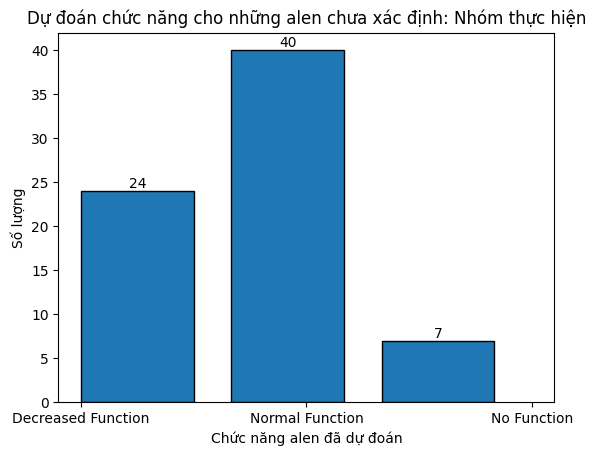

In [95]:
counts, edges, bars = plt.hist(pred_label_uncertain, bins=3, edgecolor='black', width=0.5)
plt.bar_label(bars)

plt.xlabel('Chức năng alen đã dự đoán')
plt.ylabel('Số lượng')
plt.title('Dự đoán chức năng cho những alen chưa xác định: Nhóm thực hiện')
plt.show()

In [137]:
def save_score_pred():
    data_frame_uncertain = pd.DataFrame({'Uncertain': np.array([f"*{uncurated.split('_')[1]}" for uncurated in uncerted['sample_names']]), 'Predict': pred_label_uncertain})
    # data_frame_uncertain.to_csv('../data/final_model/uncurated/predict.csv', index=False)
    alleles_function = pd.read_excel('../data/final_model/pcbi.1008399.s003.xlsx', usecols=[0, 1])
    
    for index, row in data_frame_uncertain.iterrows():
        condition = alleles_function['CYP2D6 Star Allele'] == row['Uncertain']
        alleles_function.loc[condition, 'Curated Function'] = row['Predict']

    function_to_score = alleles_function.copy()
    for index, row in function_to_score.iterrows():
        if row['Curated Function'] == 'Normal':
            function_to_score.iloc[index, 1] = 1
        elif row['Curated Function'] == 'Decreased Function':
            function_to_score.iloc[index, 1] = 0.5
        else:
            function_to_score.iloc[index, 1] = 0
    
    function_to_score = function_to_score.rename(columns={'Curated Function': 'Score'})
    
    gt_to_score = pd.read_csv('../data/final_model/CYP2D6_gt_to_score.txt', sep='\t')
    gt_to_score['reliability'] = '.'
    for index, row in gt_to_score.iterrows():
        if pd.isna(row['Activity Value']):
            condition = function_to_score['CYP2D6 Star Allele'] == row['Allele']
            score = function_to_score.loc[condition, 'Score'].values
            if len(score) > 0:
                gt_to_score.iloc[index, 1] = score
                gt_to_score.iloc[index, 3] = 'Predict by model'

    gt_to_score.to_csv('../data/final_model/uncerated/gt_to_score.txt', sep='\t', index=False, na_rep='N/A')
    print('Done!')

In [138]:
save_score_pred()

Done!


# HEAT MAP

In [62]:
def build_heatmap(pred, y, labels):
    heatmap = []
    for label in labels:
        mask = pred == label
        masked_labels = y[mask]
        heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

    return heatmap

1/1 [==============================] - 0s 369ms/step
Độ chính xác đạt được: 0.9032258064516129


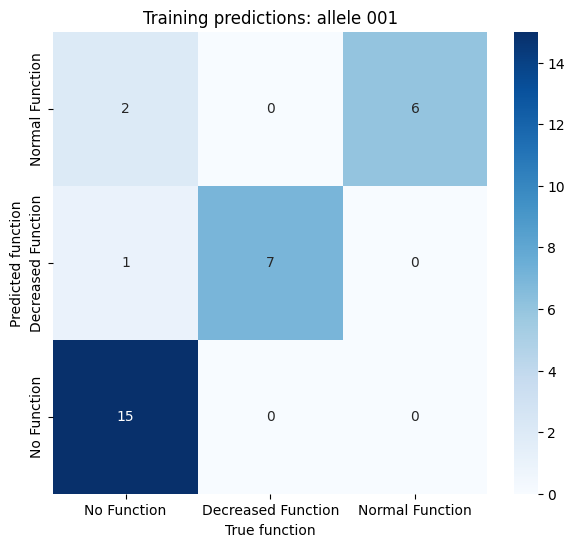

In [67]:
pred = predict(dataset_trainning[1][0])
pred_func = get_functions(pred)
y_func = get_functions(dataset_trainning[1][1])

print("Độ chính xác đạt được:", evaluation(pred_func, y_func))

labels = ["Normal Function", "Decreased Function", "No Function"]
heatmap = build_heatmap(pred_func, y_func, labels=labels)


fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(heatmap, cmap="Blues", annot=heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training predictions: allele 001")
plt.show()

2/2 [==============================] - 0s 25ms/step
Độ chính xác đạt được: 0.8448275862068966


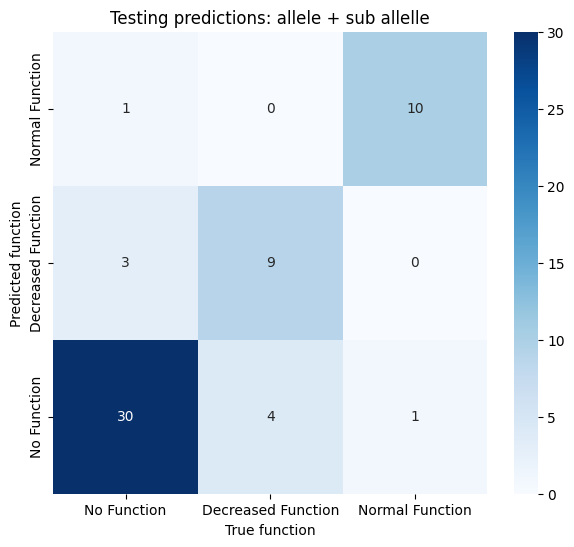

In [68]:
pred = predict(dataset_evalution[0][0])
pred_func = get_functions(pred)
y_func = get_functions(dataset_evalution[0][1])

print("Độ chính xác đạt được:", evaluation(pred_func, y_func))

labels = ["Normal Function", "Decreased Function", "No Function"]
heatmap = build_heatmap(pred_func, y_func, labels=labels)


fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(heatmap, cmap="Blues", annot=heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Testing predictions: allele + sub allelle")
plt.show()

1/1 [==============================] - 0s 212ms/step
Độ chính xác đạt được: 0.875


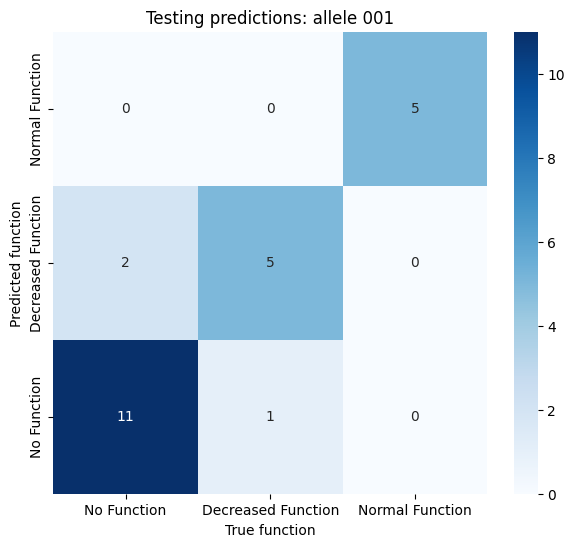

In [69]:
pred = predict(dataset_evalution[1][0])
pred_func = get_functions(pred)
y_func = get_functions(dataset_evalution[1][1])

print("Độ chính xác đạt được:", evaluation(pred_func, y_func))

labels = ["Normal Function", "Decreased Function", "No Function"]
heatmap = build_heatmap(pred_func, y_func, labels=labels)


fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(heatmap, cmap="Blues", annot=heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Testing predictions: allele 001")
plt.show()